In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import sqlite3
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32


In [2]:
fName = "../data/20190103-22-53-substorms.csv"
smlDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smlDF.columns = [ "datetime", "mlat", "mlt" ]
# convert to hour
smlDF.set_index( pandas.to_datetime(\
                        smlDF["datetime"]), inplace=True )
smlDF.head()

,datetime,mlat,mlt
datetime,,,
1996-01-01 20:16:00,1996-01-01 20:16:00,71.32,22.45
1996-01-01 23:36:00,1996-01-01 23:36:00,70.23,0.07
1996-01-02 00:25:00,1996-01-02 00:25:00,69.36,22.92
1996-01-02 14:12:00,1996-01-02 14:12:00,70.06,23.20
1996-01-02 16:09:00,1996-01-02 16:09:00,65.81,0.62


In [3]:
def pred_bin_out(row, nBins, binTimeRes):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    # Now calculate time from prev onset
    # and time to next onset
    _cpDate = row["date"]
    srchStTime = _cpDate.strftime("%Y-%m-%d %H:%M:%S")
    _nextOnsetTime = smlDF[ smlDF.index > srchStTime ].index.min()
    if not pandas.isna(_nextOnsetTime):
        _nextDelT = (_nextOnsetTime-_cpDate).total_seconds()/60.
    else:
        _nextDelT = -1
    _priorOnsetTime = smlDF[ smlDF.index < srchStTime ].index.max()
    if not pandas.isna(_priorOnsetTime):
        _priorDelT = (_cpDate-_priorOnsetTime).total_seconds()/60.
    else:
        _priorDelT = -1
    row["next_onset"] = _nextDelT
    row["prior_onset"] = _priorDelT
    # finally get the number of substorms in the bin
    srchETime = (_cpDate + datetime.timedelta(minutes=(binTimeRes+30)*nBins)\
                ).strftime("%Y-%m-%d %H:%M:%S")
    row["num_onsets"] = len( smlDF[ srchStTime : srchETime ].index.tolist() )
    return row

In [4]:
colNames = ["date"]
nBins = 1
binRes = 60
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
# colNames += [ "label", "del_sml","del_sme","min_sml","max_sme","pred_label" ]
colNames += [ "label", "pred_label" ]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
predDF = pandas.read_csv("../data/all_data_pred.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF = predDF.apply( pred_bin_out, args=(nBins,binRes,),\
                      axis=1 )
# filter out -ve next onsets
predDF["diff_onsets"] = predDF["next_onset"] + predDF["prior_onset"]
# Also set a new term "time_from_pred_horizon" which is equal to 
# next_onset - pred_bin_time (60 min), this is equivalent
# to the time by which the prediction was missed.
predDF["time_from_pred_horizon"] = predDF["next_onset"] - binRes
predDF.head()

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type,next_onset,prior_onset,num_onsets,diff_onsets,time_from_pred_horizon
0,1997-01-01 00:00:00,0,0,0,0.933373,0.066627,0,TN,136.0,262.0,0,398.0,76.0
1,1997-01-01 01:50:00,1,1,0,0.933373,0.066627,0,FN,26.0,372.0,1,398.0,-34.0
2,1997-01-01 01:55:00,1,1,0,0.933373,0.066627,0,FN,21.0,377.0,1,398.0,-39.0
3,1997-01-01 02:00:00,1,1,0,0.933373,0.066627,0,FN,16.0,382.0,1,398.0,-44.0
4,1997-01-01 02:05:00,1,1,0,0.933373,0.066627,0,FN,11.0,387.0,1,398.0,-49.0


In [5]:
start_date = predDF["date"].min() - datetime.timedelta(hours=2)
end_date = predDF["date"].max()
print start_date, end_date

1996-12-31 22:00:00 2017-12-31 23:55:00


In [6]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "smu_sml_sme.sqlite"
omn_table_name = "smusmlsme"

In [7]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.set_index(smlDF["datetime"], inplace=True)
smlDF.head()

,datetime,al,ae,au
datetime,,,,
1996-12-31 22:00:00,1996-12-31 22:00:00,-9,82,73
1996-12-31 22:01:00,1996-12-31 22:01:00,-10,65,55
1996-12-31 22:02:00,1996-12-31 22:02:00,-11,65,54
1996-12-31 22:03:00,1996-12-31 22:03:00,-13,83,70
1996-12-31 22:04:00,1996-12-31 22:04:00,-21,97,76


In [8]:
def get_sml_vars(row):
    """
    Get mean, median, std, min and max of sml 
    during various substorms over the next interval range.
    """
    delTimeList = [30, 60]#[ 15, 30, 60, 120 ]
    for _dtl in delTimeList:
        _pd = row["date"] - datetime.timedelta(minutes=10)
        _cd = row["date"] + datetime.timedelta(minutes=1)
        _ed = row["date"] + datetime.timedelta(minutes=_dtl)
        _resDF = smlDF[ _cd : _ed ]
        _baselineAl = smlDF[ _pd : _cd ]["al"].median()
        _baselineAe = smlDF[ _pd : _cd ]["ae"].median()
        row["mean_al_" + str(_dtl)] = _resDF["al"].mean()
        row["median_al_" + str(_dtl)] = _resDF["al"].median()
        row["min_al_" + str(_dtl)] = _resDF["al"].min()
        row["max_al_" + str(_dtl)] = _resDF["al"].max()
        # difference between current AL and minimum in the next bin
        # note this is defined to be negative, for easy binning etc
        row["al_dip" + str(_dtl)] = _resDF["al"].min() - _baselineAl
        row["ae_dip" + str(_dtl)] = _resDF["ae"].max() - _baselineAe
    return row

predDF = predDF.apply( get_sml_vars, axis=1 )
predDF.head()

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type,next_onset,prior_onset,...,min_al_30,max_al_30,al_dip30,ae_dip30,mean_al_60,median_al_60,min_al_60,max_al_60,al_dip60,ae_dip60
0,1997-01-01 00:00:00,0,0,0,0.933373,0.066627,0,TN,136.0,262.0,...,-193.0,-38.0,-162.5,256.0,-107.850000,-96.0,-193.0,-38.0,-162.5,256.0
1,1997-01-01 01:50:00,1,1,0,0.933373,0.066627,0,FN,26.0,372.0,...,-287.0,-77.0,-230.0,266.0,-158.433333,-156.5,-287.0,-77.0,-230.0,266.0
2,1997-01-01 01:55:00,1,1,0,0.933373,0.066627,0,FN,21.0,377.0,...,-287.0,-77.0,-164.5,158.0,-162.633333,-161.5,-287.0,-77.0,-164.5,158.0
3,1997-01-01 02:00:00,1,1,0,0.933373,0.066627,0,FN,16.0,382.0,...,-287.0,-77.0,-149.0,139.0,-164.600000,-163.5,-287.0,-77.0,-149.0,139.0
4,1997-01-01 02:05:00,1,1,0,0.933373,0.066627,0,FN,11.0,387.0,...,-287.0,-77.0,-156.0,157.0,-170.433333,-172.0,-287.0,-77.0,-156.0,157.0


In [9]:
predDF[ predDF["pred_type"] == "FP" ].describe()

,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,next_onset,prior_onset,num_onsets,diff_onsets,...,min_al_30,max_al_30,al_dip30,ae_dip30,mean_al_60,median_al_60,min_al_60,max_al_60,al_dip60,ae_dip60
count,52233.0,52233.0,52233.0,52233.000000,52233.000000,52233.0,52233.000000,52233.000000,52233.000000,52233.000000,...,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000,52232.000000
mean,0.0,0.0,1.0,0.319492,0.680508,1.0,401.352785,339.643788,0.398752,740.996573,...,-346.198365,-199.611177,-74.793824,100.976777,-252.090678,-243.432618,-387.783447,-162.660227,-116.378906,157.837245
std,0.0,0.0,0.0,0.114170,0.114170,0.0,798.269721,772.512891,0.639500,1194.177038,...,439.128598,401.538402,112.568096,901.981603,405.267897,405.343165,439.293907,393.227187,140.188663,1255.550908
min,0.0,0.0,1.0,0.003171,0.500018,1.0,-1.000000,1.000000,0.000000,5.000000,...,-15198.000000,-15188.000000,-2986.500000,-522.500000,-15186.750000,-15188.000000,-15198.000000,-15174.000000,-2986.500000,-522.500000
25%,0.0,0.0,1.0,0.230754,0.583329,1.0,74.000000,40.000000,0.000000,181.000000,...,-435.000000,-255.000000,-109.500000,16.000000,-314.087500,-305.500000,-480.000000,-203.000000,-170.000000,35.500000
50%,0.0,0.0,1.0,0.328981,0.671019,1.0,159.000000,111.000000,0.000000,338.000000,...,-276.000000,-150.000000,-49.500000,64.500000,-203.116667,-193.500000,-325.000000,-119.000000,-84.000000,105.000000
75%,0.0,0.0,1.0,0.416671,0.769246,1.0,370.000000,294.000000,1.000000,751.000000,...,-169.000000,-81.000000,-11.000000,136.000000,-126.775000,-118.000000,-210.000000,-65.000000,-27.000000,205.500000
max,0.0,0.0,1.0,0.499982,0.996829,1.0,15855.000000,18270.000000,4.000000,18404.000000,...,-16.000000,6.000000,533.000000,89227.500000,-15.816667,-13.000000,-22.000000,6.000000,533.000000,89235.500000


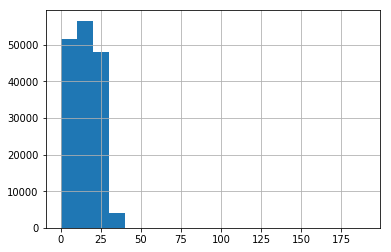

In [10]:
bins = range(0,200,10)#[0,10,20,40,60,120,240,2400]
predDF[ predDF["pred_type"] == "TP" ]["next_onset"].hist(bins=bins)

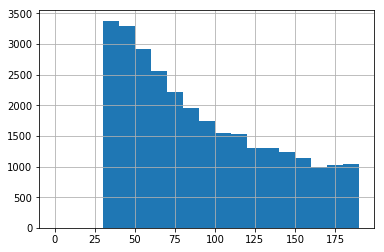

In [11]:
predDF[ predDF["pred_type"] == "FP" ]["next_onset"].hist(bins=bins)

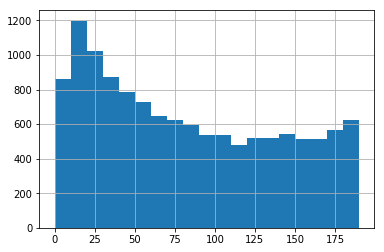

In [12]:
predDF[ predDF["pred_type"] == "FN" ]["prior_onset"].hist(bins=bins)

In [13]:
nOnsetGrp = predDF.groupby( [ "pred_type", "num_onsets" ] ).size()
print nOnsetGrp

pred_type  num_onsets
FN         1              29188
           2               6843
           3               1298
           4                111
FP         0              35477
           1              13025
           2               3396
           3                329
           4                  6
TN         0             136125
           1               8438
           2                860
           3                 38
TP         1              82421
           2              54279
           3              20724
           4               2809
           5                 21
dtype: int64


(0, 400)

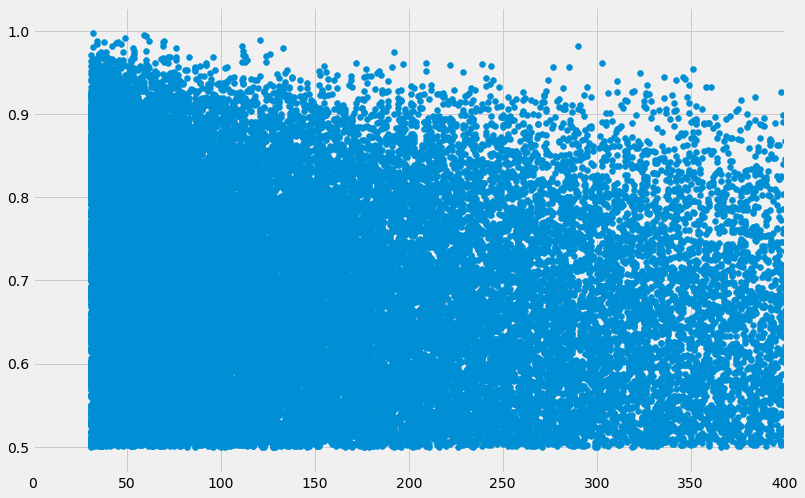

In [14]:
plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
selDF = predDF[ predDF["pred_type"] == "FP" ]
ax.scatter(selDF["next_onset"].values, selDF["prob_type_1_b_0"].values)
ax.set_xlim([0,400])

In [15]:
# Divide time_from_pred_horizon  into bins
timeBins = range(0,205,15)
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["time_from_pred_horizon"], \
                               bins=timeBins ) ], axis=1 )
predDF.columns = oldColNames + ["time_bin"]
predDF.head() 

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type,next_onset,prior_onset,...,max_al_30,al_dip30,ae_dip30,mean_al_60,median_al_60,min_al_60,max_al_60,al_dip60,ae_dip60,time_bin
0,1997-01-01 00:00:00,0,0,0,0.933373,0.066627,0,TN,136.0,262.0,...,-38.0,-162.5,256.0,-107.850000,-96.0,-193.0,-38.0,-162.5,256.0,"(75, 90]"
1,1997-01-01 01:50:00,1,1,0,0.933373,0.066627,0,FN,26.0,372.0,...,-77.0,-230.0,266.0,-158.433333,-156.5,-287.0,-77.0,-230.0,266.0,NaN
2,1997-01-01 01:55:00,1,1,0,0.933373,0.066627,0,FN,21.0,377.0,...,-77.0,-164.5,158.0,-162.633333,-161.5,-287.0,-77.0,-164.5,158.0,NaN
3,1997-01-01 02:00:00,1,1,0,0.933373,0.066627,0,FN,16.0,382.0,...,-77.0,-149.0,139.0,-164.600000,-163.5,-287.0,-77.0,-149.0,139.0,NaN
4,1997-01-01 02:05:00,1,1,0,0.933373,0.066627,0,FN,11.0,387.0,...,-77.0,-156.0,157.0,-170.433333,-172.0,-287.0,-77.0,-156.0,157.0,NaN


In [16]:
# Bin by AL
alBins = range(-1500,100,100)
# get the min al in the next 30 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["min_al_30"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["min_al_30_bin"]
# get the min al in the next 60 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["min_al_60"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["min_al_60_bin"]
# get the AL in the next 30 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["al_dip30"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["al_dip30_bin"]
# get the AL in the next 60 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["al_dip60"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["al_dip60_bin"]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

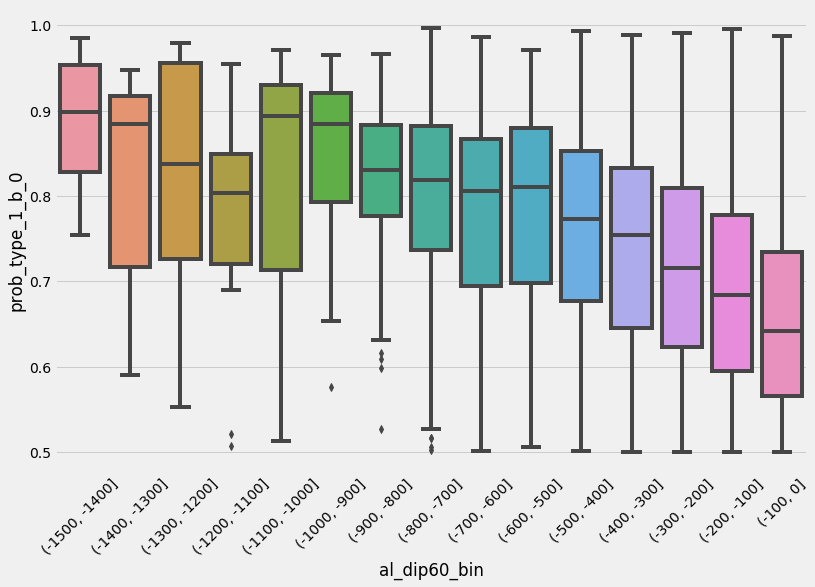

In [17]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.boxplot( x="al_dip60_bin", y="prob_type_1_b_0",\
            data=predDF[predDF["pred_type"] == "FP"], ax=ax1 )
plt.xticks(rotation=45)

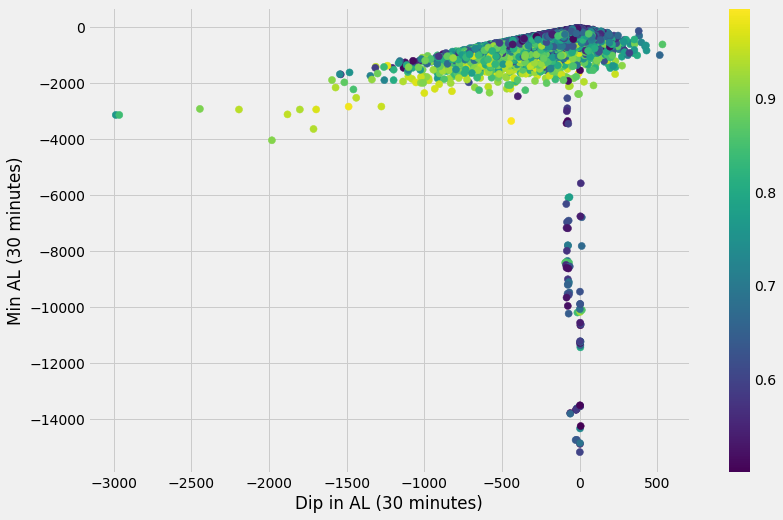

In [18]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
dataDF = predDF[predDF["pred_type"] == "FP"]
sctPlot = ax1.scatter( dataDF["al_dip60"].values, dataDF["min_al_60"].values,\
            c=dataDF["prob_type_1_b_0"].values, marker="o", s=50. )
# dataDF = predDF[predDF["pred_type"] == "FP"]
# sctPlot = ax1.scatter( dataDF["al_dip30"].values, dataDF["min_al_30"].values,\
#             c=dataDF["prob_type_1_b_0"].values, marker="x", s=50. )
# dataDF = predDF[predDF["pred_type"] == "TN"]
# sctPlot = ax1.scatter( dataDF["al_dip30"].values, dataDF["min_al_30"].values,\
#             c=dataDF["prob_type_1_b_0"].values, marker="s", s=50. )
# dataDF = predDF[predDF["pred_type"] == "FN"]
# sctPlot = ax1.scatter( dataDF["al_dip30"].values, dataDF["min_al_30"].values,\
#             c=dataDF["prob_type_1_b_0"].values, marker="d", s=50. )

plt.colorbar(sctPlot)
ax1.set_xlabel("Dip in AL (30 minutes)")
ax1.set_ylabel("Min AL (30 minutes)")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

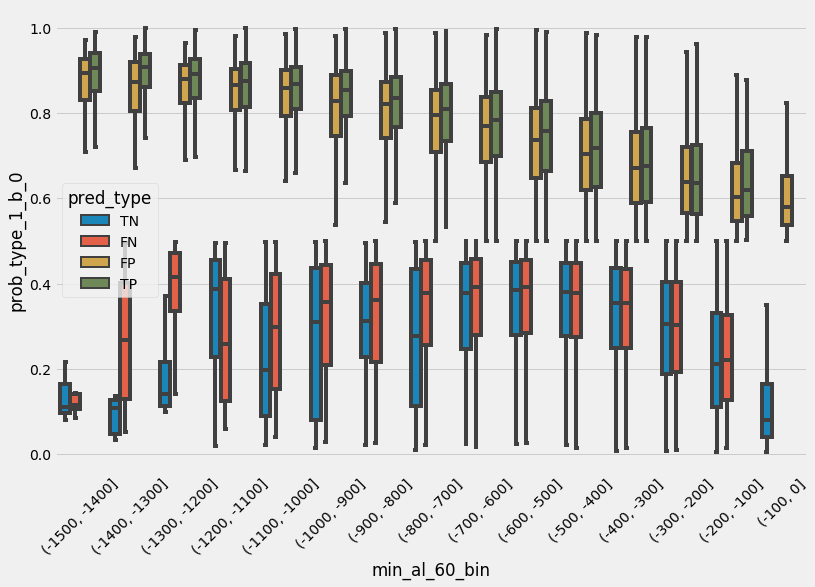

In [19]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.boxplot( x="min_al_60_bin", y="prob_type_1_b_0", hue="pred_type",\
            data=predDF, showfliers=False, ax=ax1 )
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

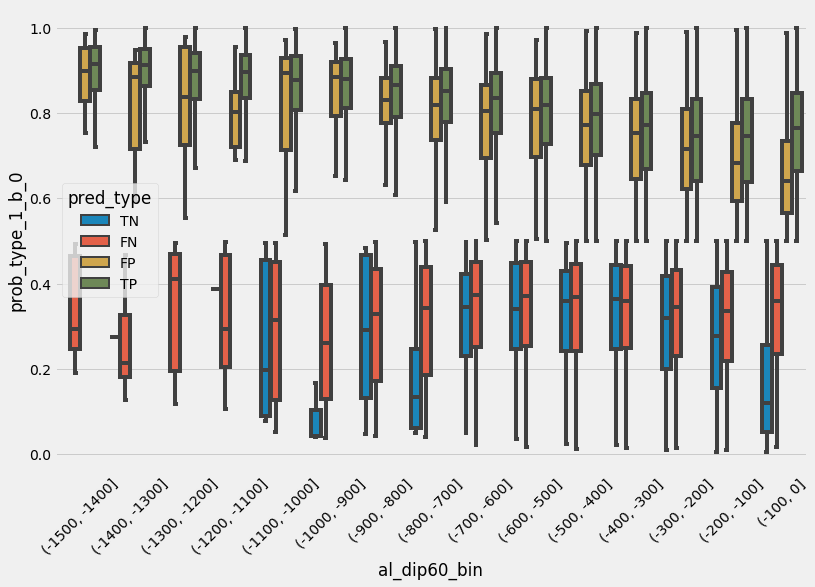

In [20]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.boxplot( x="al_dip60_bin", y="prob_type_1_b_0", hue="pred_type",\
            data=predDF, showfliers=False, ax=ax1 )
plt.xticks(rotation=45)

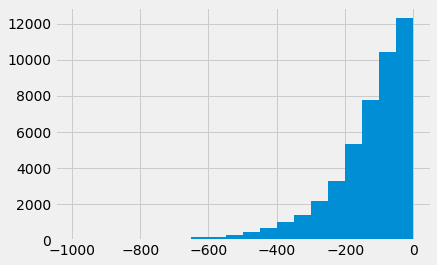

In [21]:
alBins = range(-1000,50,50)
predDF[ predDF["pred_type"] == "FP" ]["al_dip60"].hist(bins=alBins)

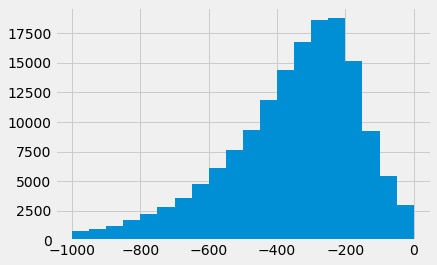

In [22]:
predDF[ predDF["pred_type"] == "TP" ]["al_dip60"].hist(bins=alBins)

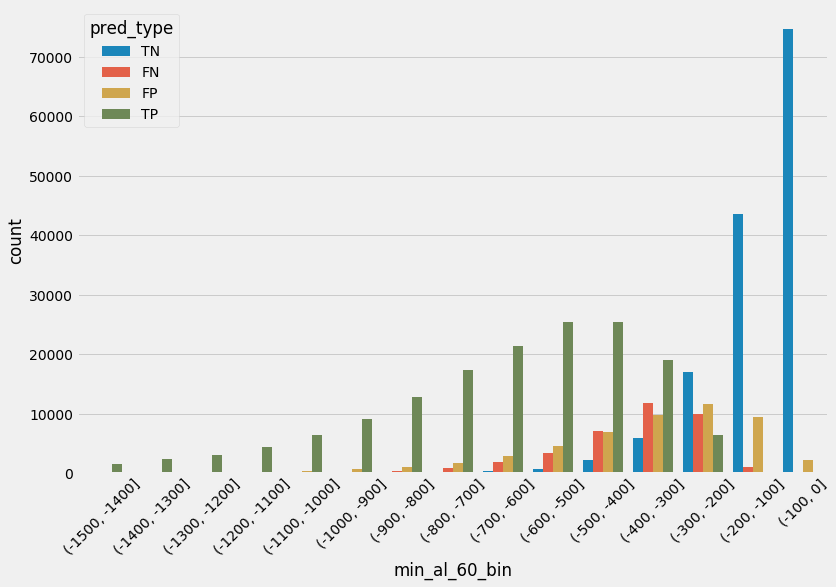

In [23]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.countplot(x="min_al_60_bin", hue="pred_type", data=predDF, ax=ax1)
plt.xticks(rotation=45)
f.savefig("../plots/categorical_sml_min_hist.pdf", bbox_inches='tight')

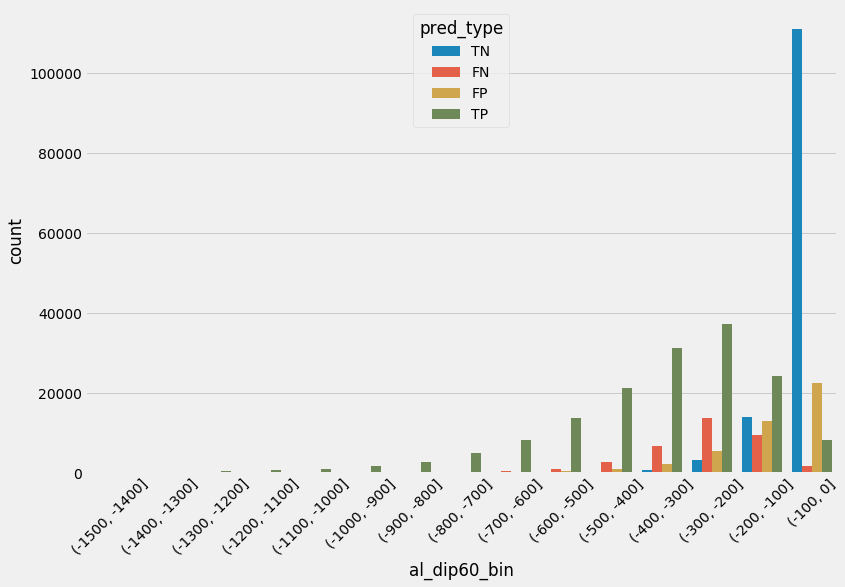

In [24]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.countplot(x="al_dip60_bin", hue="pred_type", data=predDF, ax=ax1)
plt.xticks(rotation=45)
f.savefig("../plots/categorical_sml_dip_hist.pdf", bbox_inches='tight')